In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
%matplotlib inline

In [3]:
data = np.loadtxt('./wine.data.txt', delimiter=',')
featurenames = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash','Magnesium', 'Total phenols', 
                'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 
                'OD280/OD315 of diluted wines', 'Proline']

In [13]:
print(data.shape[0], data.shape[1])

whole_size = data.shape[0]
train_size = 130
feature_size = data.shape[1]

np.random.seed(0)
perm = np.random.permutation(whole_size)
trainx = data[perm[0:train_size], 1:feature_size]
trainy = data[perm[0:130],0]
testx = data[perm[train_size:],1:feature_size]
testy = data[perm[train_size:], 0]

178 14


In [14]:
print(trainx.shape, trainy.shape, testx.shape, testy.shape)

(130, 13) (130,) (48, 13) (48,)


In [15]:
sum(trainy==1), sum(trainy==2), sum(trainy==3)

(43, 54, 33)

## Question: there are class 1: 43, class 2: 54, class 3: 33

(array([ 1.,  7.,  4.,  6.,  7.,  1., 10.,  5.,  0.,  2.]),
 array([12.85 , 13.048, 13.246, 13.444, 13.642, 13.84 , 14.038, 14.236,
        14.434, 14.632, 14.83 ]),
 <a list of 10 Patch objects>)

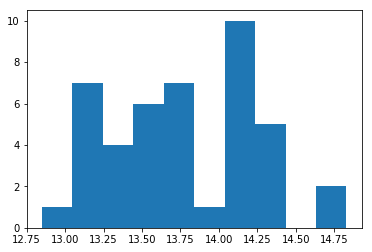

In [22]:
class1 = trainx[trainy==1]
plt.hist(class1[:,0])

In [23]:
@interact_manual(feature=IntSlider(0,0,12), label=IntSlider(1,1,3))
def density_plot(feature, label):
    plt.hist(trainx[trainy==label,feature], normed=True)
    mu = np.mean(trainx[trainy==label,feature])
    var = np.var(trainx[trainy==label,feature])
    std = np.sqrt(var)
    
    x_axis = np.linspace(mu-3*std, mu+3*std, 1000)
    plt.plot(x_axis, norm.pdf(x_axis,mu,std), 'r', lw=2)
    plt.title("Winery "+str(label))
    plt.xlabel(featurenames[feature], fontsize=14, color='red')
    plt.ylabel('Density', fontsize=14, color='red')
    plt.show()

Widget Javascript not detected.  It may not be installed or enabled properly.


In [29]:
std_feature = [np.std(trainx[trainy==1,i]) for i in range(0,13)]
print(std_feature)
ind_min = std_feature.index(min(std_feature))
ind_max = std_feature.index(max(std_feature))
print('min var is: ', ind_min, ' , ', featurenames[ind_min])
print('max var is: ', ind_max, ' , ', featurenames[ind_max])

[0.482962509196465, 0.6567567855698971, 0.19176727828566711, 2.45766535216538, 10.884019077609793, 0.3437341470851615, 0.3903964785857551, 0.05964288894974403, 0.45327436810974586, 1.2246337627607105, 0.11543320245628266, 0.3558463277565554, 220.10397267776506]
min var is:  7  ,  Nonflavanoid phenols
max var is:  12  ,  Proline


## for class 1, the min variance is feature=Nonflavanoid phenols, the max variance is feature = Proline

In [31]:
# define a function to fit Gaussian
def fit_generative_model(x,y,feature):
    k = 3
    mu = np.zeros(k+1)
    var = np.zeros(k+1)
    pi = np.zeros(k+1)
    for label in range(1,k+1):
        indices = (y==label)
        mu[label] = np.mean(x[indices, feature])
        var[label] = np.var(x[indices, feature])
        pi[label] = float(sum(indices))/float(len(y))
    return mu,var,pi

In [33]:
feature = 0 # 'alcohol'
mu, var, pi = fit_generative_model(trainx, trainy, feature)
print(pi[1:])

[0.33076923 0.41538462 0.25384615]
